In [1]:
! pip install pyspark

In [2]:
! pip install numpy


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import logging

In [4]:
spark = SparkSession.builder \
    .appName("DataCo - Prédiction Retards") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()


In [5]:
df = spark.read.csv("../data/DataCoSupplyChainDataset.csv" , header=True , inferSchema=True )

In [6]:
df.count()


180519

In [7]:
len(df.columns)

53

In [8]:
df_status_Late_delivery_risk=df.groupBy("Late_delivery_risk").count()
print("Nombre d'occurrences par catégorie de 'Late_delivery_risk':")
df_status_Late_delivery_risk.show()

Nombre d'occurrences par catégorie de 'Late_delivery_risk':
+------------------+-----+
|Late_delivery_risk|count|
+------------------+-----+
|                 1|98977|
|                 0|81542|
+------------------+-----+



In [9]:
df.groupBy("Delivery Status").count()
print("Nombre d'occurrences par catégorie de 'Delivery Status':")
df.groupBy("Delivery Status").count().show()

Nombre d'occurrences par catégorie de 'Delivery Status':
+-----------------+-----+
|  Delivery Status|count|
+-----------------+-----+
| Shipping on time|32196|
| Advance shipping|41592|
|Shipping canceled| 7754|
|    Late delivery|98977|
+-----------------+-----+



In [10]:
df.show(5)

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per c

Analyse : on supprime les lignes qui contient delivery status == Shipping canceled 

In [11]:
from pyspark.sql.functions import col
df_cleaned = df.filter(col("Delivery Status") != "Shipping canceled")

In [12]:
# ici je verfier est ce que les colis avec "Advance shipping" ont pas de risque de  retard , pour verifier la qualite de donnees
df_analyse= df.select(col("Late_delivery_risk")).filter(col("Delivery Status") == "Advance shipping").groupBy("Late_delivery_risk").count()
df_analyse.show()

+------------------+-----+
|Late_delivery_risk|count|
+------------------+-----+
|                 0|41592|
+------------------+-----+



In [13]:
df_status_Late_delivery_risk=df_cleaned.groupBy("Late_delivery_risk").count() 

# Ajouter une colonne pourcentage
df_status_Late_delivery_risk = df_status_Late_delivery_risk.withColumn(
    "percentage %",
    round(col("count") / df_cleaned.count() * 100, 2)  # arrondi à 2 décimales
)


print("Nombre d'occurrences par catégorie de 'Late_delivery_risk':")
df_status_Late_delivery_risk.show()

Nombre d'occurrences par catégorie de 'Late_delivery_risk':
+------------------+-----+------------+
|Late_delivery_risk|count|percentage %|
+------------------+-----+------------+
|                 1|98977|       57.29|
|                 0|73788|       42.71|
+------------------+-----+------------+



Analyse :  57.29 % ont un retard , alors nos donnees sont equilibré

maintenant on passe a la supprission des colonnes inutils 

In [14]:
cols_to_drop = [
    "Customer Email",  
    "Customer Password", 
    "Customer Street",
    "Customer Zipcode",
    "Customer Fname", 
    "Customer Lname", 
    "Product Description", 
    "Product Image",
    "Order Zipcode", 
    "Order Customer Id", 
    "Order Item Cardprod Id", 
    "Order Item Id",
    "Product Card Id",
    "Customer Id", 
    "Days for shipping (real)",
    "Category Name" ,
    "Department Name" ,
    "Product Name" ,
    "Benefit per order" ,
    "Sales per customer"
]


# Garde seulement les colonnes qui existent dans le DataFrame
existing_cols_to_drop = [c for c in cols_to_drop if c in df_cleaned.columns]

# Supprimer ces colonnes
df_cleaned = df_cleaned.drop(*existing_cols_to_drop)

# Vérifier les colonnes restantes
df_cleaned.columns



['Type',
 'Days for shipment (scheduled)',
 'Delivery Status',
 'Late_delivery_risk',
 'Category Id',
 'Customer City',
 'Customer Country',
 'Customer Segment',
 'Customer State',
 'Department Id',
 'Latitude',
 'Longitude',
 'Market',
 'Order City',
 'Order Country',
 'order date (DateOrders)',
 'Order Id',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'Order Item Total',
 'Order Profit Per Order',
 'Order Region',
 'Order State',
 'Order Status',
 'Product Category Id',
 'Product Price',
 'Product Status',
 'shipping date (DateOrders)',
 'Shipping Mode']

In [15]:
len(df_cleaned.columns)

33

In [16]:
from pyspark.sql.functions import col, mean

# Calculer le pourcentage de retards par mode d'expédition
df_risk_by_mode = df_cleaned.groupBy("Shipping Mode") \
    .agg(mean(col("Late_delivery_risk")).alias("Late_delivery_rate")) \
    .orderBy(col("Late_delivery_rate").desc())

df_risk_by_mode.show()


+--------------+-------------------+
| Shipping Mode| Late_delivery_rate|
+--------------+-------------------+
|   First Class|                1.0|
|  Second Class| 0.7982902443353251|
|      Same Day|0.47928548369740664|
|Standard Class|0.39769080879858076|
+--------------+-------------------+



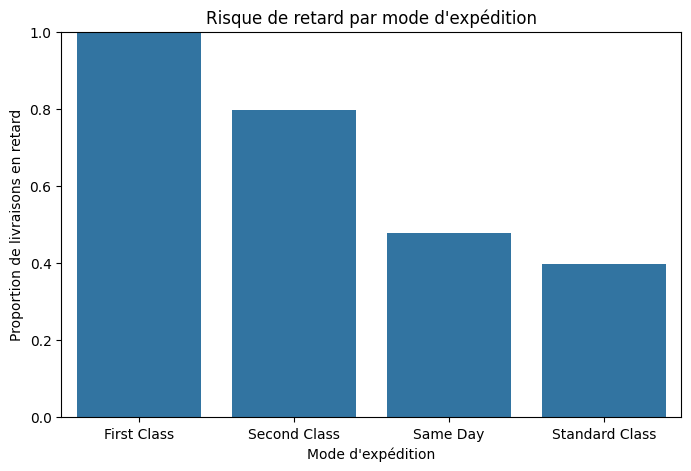

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conversion en Pandas
df_risk_pd = df_risk_by_mode.toPandas()

# Bar plot
plt.figure(figsize=(8,5))
sns.barplot(x="Shipping Mode", y="Late_delivery_rate", data=df_risk_pd)
plt.title("Risque de retard par mode d'expédition")
plt.ylabel("Proportion de livraisons en retard")
plt.xlabel("Mode d'expédition")
plt.ylim(0, 1)
plt.show()


## VARIANCE

In [18]:
from pyspark.sql.functions import col, variance
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

# 1️⃣ Sélectionner les colonnes numériques
numeric_cols = [c for c, t in df_cleaned.dtypes if t in ['int', 'double', 'float'] and c not in ['Late_delivery_risk', 'Order Id']]

# 2️⃣ Calculer la variance de chaque colonne
variances = (
    df_cleaned.select([variance(col(c)).alias(c) for c in numeric_cols])
    .collect()[0]
    .asDict()
)

# 3️⃣ Choisir un seuil de variance (comme sklearn.threshold=0.01)
threshold = 0.01

# 4️⃣ Séparer features gardées / supprimées
features_gardees = [c for c, v in variances.items() if v is not None and v > threshold]
features_supprimees = [c for c, v in variances.items() if v is None or v <= threshold]

# 5️⃣ Créer un nouveau DataFrame filtré
df_var = df_cleaned.select(features_gardees + ['Late_delivery_risk'])

# 6️⃣ Afficher les résultats
print(f"✅ Features gardées ({len(features_gardees)}) : {features_gardees}")
print(f"❌ Features supprimées ({len(features_supprimees)}) : {features_supprimees}")




✅ Features gardées (14) : ['Days for shipment (scheduled)', 'Category Id', 'Department Id', 'Latitude', 'Longitude', 'Order Item Discount', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Product Category Id', 'Product Price']
❌ Features supprimées (2) : ['Order Item Discount Rate', 'Product Status']


Analyse : 
❌ Features supprimées (2) : ['Order Item Discount Rate', 'Product Status']
apres la correlation on a constater que ces deux features n'apportent pas d'information pertinente pour la prédiction
et apres l analyse des valeurs avec group by on a constater que ces deux features n ont pas de relation claire avec la variable cible 'Late_delivery_risk'

In [19]:
df_cleaned = df_cleaned.drop('Order Item Discount Rate', 'Product Status')


In [20]:
len(df_cleaned.columns)

31

## CORRELATION 

In [21]:
df_cleaned.cache()  # On demande à Spark de mettre le DataFrame en cache pour le réutiliser plus tard
df_cleaned.count()


172765

In [22]:
! pip install seaborn

In [23]:
NUMERIC_COLS = [c for c, t in df_cleaned.dtypes if t in ['int', 'double', 'float'] and c != 'Late_delivery_risk']

                               Days for shipment (scheduled)  Category Id  \
Days for shipment (scheduled)                       1.000000     0.000238   
Category Id                                         0.000238     1.000000   
Department Id                                       0.000142     0.889059   
Latitude                                           -0.006350     0.003128   
Longitude                                           0.004745    -0.003433   
Order Id                                           -0.000877     0.198085   
Order Item Discount                                 0.002805     0.140227   
Order Item Product Price                            0.007125     0.460492   
Order Item Profit Ratio                            -0.002144    -0.001380   
Order Item Quantity                                -0.002897    -0.302490   
Sales                                               0.006534     0.227083   
Order Item Total                                    0.006691     0.224774   

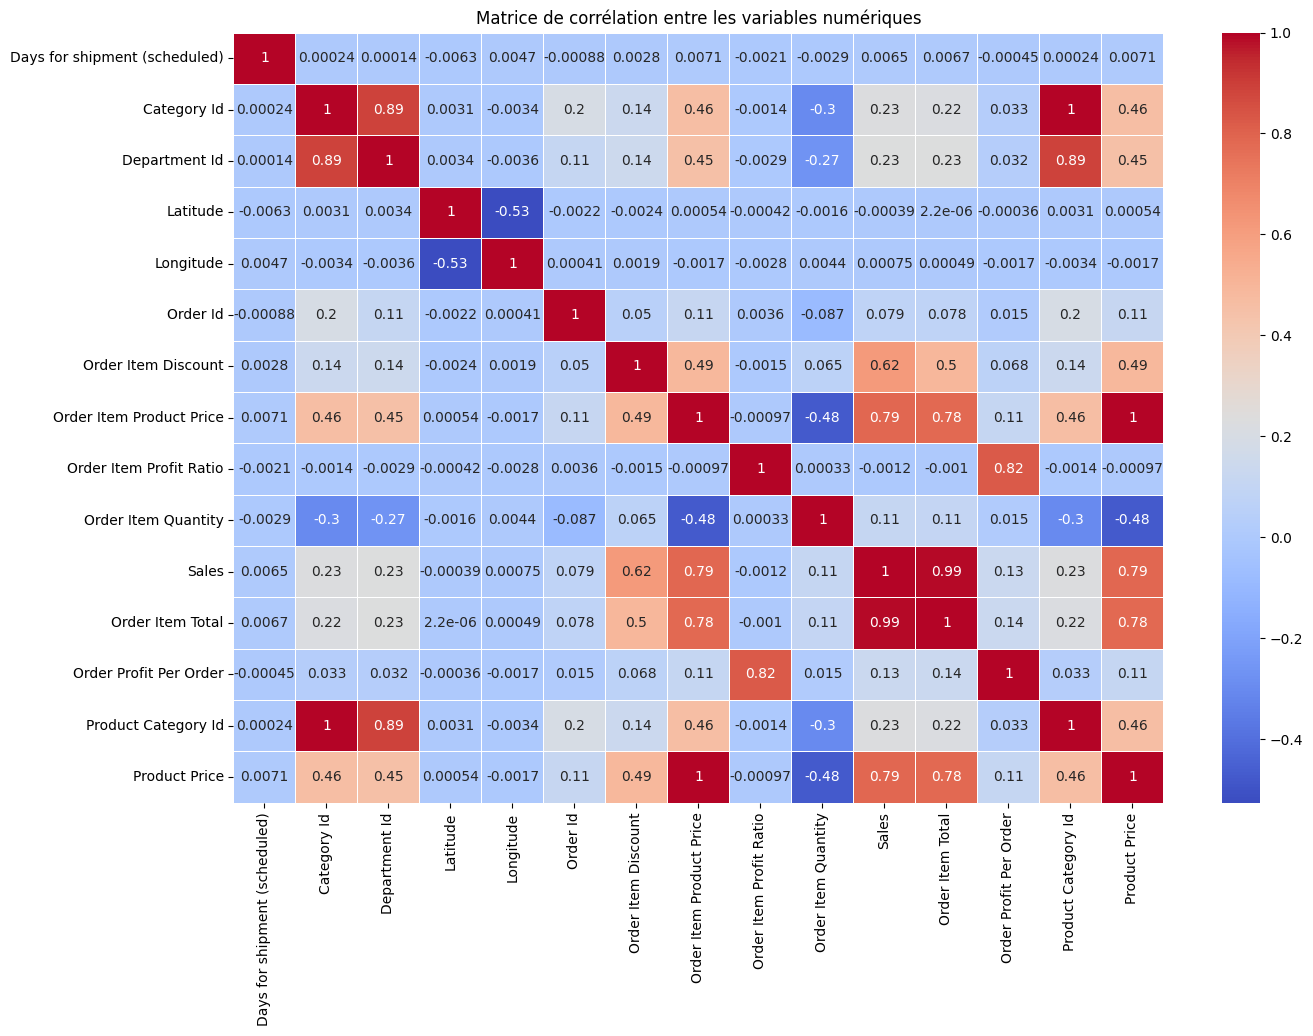

In [24]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des colonnes numériques
numeric_df = df_cleaned.select([col(c).cast("double") for c in NUMERIC_COLS])

# Conversion en pandas pour calculer la matrice de corrélation
pandas_df = numeric_df.toPandas()

# Calcul de la matrice de corrélation
corr_matrix = pandas_df.corr()

# Affichage sous forme de tableau
print(corr_matrix)

# Visualisation graphique (heatmap)
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de corrélation entre les variables numériques")
plt.show()


# correlation plus de 0.8

                   Variable_1                Variable_2  Correlation
28                Category Id       Product Category Id     1.000000
119  Order Item Product Price             Product Price     1.000000
196       Product Category Id               Category Id     1.000000
217             Product Price  Order Item Product Price     1.000000
161                     Sales          Order Item Total     0.989754
175          Order Item Total                     Sales     0.989754
17                Category Id             Department Id     0.889059
31              Department Id               Category Id     0.889059
43              Department Id       Product Category Id     0.889059
197       Product Category Id             Department Id     0.889059
132   Order Item Profit Ratio    Order Profit Per Order     0.823472
188    Order Profit Per Order   Order Item Profit Ratio     0.823472


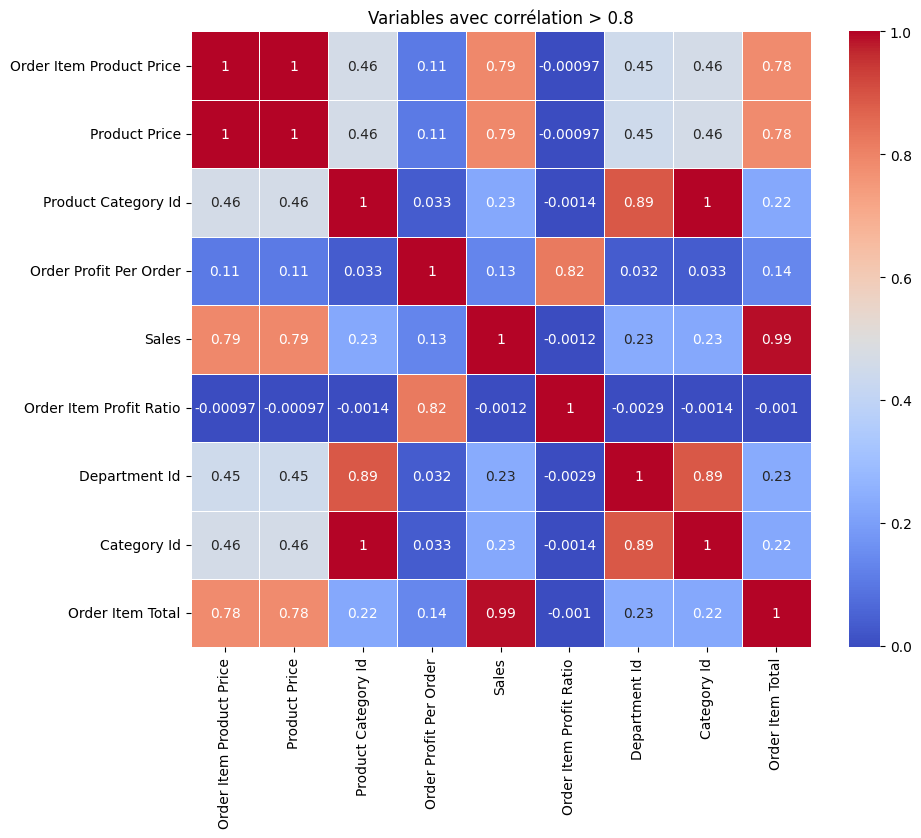

In [25]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df_cleaned.select([col(c).cast("double") for c in NUMERIC_COLS])
pandas_df = numeric_df.toPandas()
corr_matrix = pandas_df.corr()

corr_pairs = (
    corr_matrix.unstack()
    .reset_index()
    .rename(columns={'level_0': 'Variable_1', 'level_1': 'Variable_2', 0: 'Correlation'})
)

high_corr = corr_pairs[
    (corr_pairs['Variable_1'] != corr_pairs['Variable_2']) &
    (corr_pairs['Correlation'].abs() > 0.8)
].sort_values(by='Correlation', ascending=False).drop_duplicates()

print(high_corr)

# 🔧 Correction : convertir en liste
cols_high_corr = list(set(high_corr['Variable_1']).union(set(high_corr['Variable_2'])))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[cols_high_corr, cols_high_corr], annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Variables avec corrélation > 0.8")
plt.show()


In [26]:
# Suppression des colonnes à haute corrélation
cols_to_drop = [
    "Department Id",
    "Order Profit Per Order",
    "Order Item Total",
    "Order Item Product Price",
    "Product Category Id"
]

# Garde seulement les colonnes qui existent dans le DataFrame
existing_cols_to_drop = [c for c in cols_to_drop if c in df_cleaned.columns]

print(f"📋 Colonnes à supprimer : {len(existing_cols_to_drop)}")
print(existing_cols_to_drop)

# ✅ SUPPRESSION PYSPARK (méthode correcte)
df_cleaned = df_cleaned.drop(*existing_cols_to_drop)

# Vérifier les colonnes restantes
print(f"\n✅ Colonnes restantes : {len(df_cleaned.columns)}")
print(df_cleaned.columns)

# Vérifier que les colonnes ont bien disparu
print("\n🔍 Vérification :")
for col in cols_to_drop:
    if col in df_cleaned.columns:
        print(f"❌ ERREUR : '{col}' est toujours présente !")
    else:
        print(f"✅ '{col}' supprimée avec succès")

📋 Colonnes à supprimer : 5
['Department Id', 'Order Profit Per Order', 'Order Item Total', 'Order Item Product Price', 'Product Category Id']

✅ Colonnes restantes : 26
['Type', 'Days for shipment (scheduled)', 'Delivery Status', 'Late_delivery_risk', 'Category Id', 'Customer City', 'Customer Country', 'Customer Segment', 'Customer State', 'Latitude', 'Longitude', 'Market', 'Order City', 'Order Country', 'order date (DateOrders)', 'Order Id', 'Order Item Discount', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Region', 'Order State', 'Order Status', 'Product Price', 'shipping date (DateOrders)', 'Shipping Mode']

🔍 Vérification :
✅ 'Department Id' supprimée avec succès
✅ 'Order Profit Per Order' supprimée avec succès
✅ 'Order Item Total' supprimée avec succès
✅ 'Order Item Product Price' supprimée avec succès
✅ 'Product Category Id' supprimée avec succès


In [27]:
len(df_cleaned.columns)



26

In [28]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Sélection des colonnes numériques (sauf la target)
NUMERIC_COLS = [c for c, t in df_cleaned.dtypes if t in ['int', 'double', 'float'] and c != 'Late_delivery_risk']

# 2️⃣ Conversion en double et en pandas
numeric_df = df_cleaned.select([col(c).cast("double").alias(c) for c in NUMERIC_COLS])
pandas_df = numeric_df.toPandas()

# 3️⃣ Nettoyer les noms de colonnes pour éviter les problèmes dans seaborn
pandas_df.columns = [c.replace(" ", "_").replace("(", "").replace(")", "") for c in pandas_df.columns]

# 4️⃣ Matrice de corrélation
corr_matrix = pandas_df.corr()

# 5️⃣ Trouver les paires fortement corrélées
corr_pairs = (
    corr_matrix.unstack()
    .reset_index()
    .rename(columns={'level_0': 'Variable_1', 'level_1': 'Variable_2', 0: 'Correlation'})
)

high_corr = corr_pairs[
    (corr_pairs['Variable_1'] != corr_pairs['Variable_2']) &
    (corr_pairs['Correlation'].abs() > 0.8)
].sort_values(by='Correlation', ascending=False).drop_duplicates()

print("Paires fortement corrélées (>0.8) :\n", high_corr)

# 6️⃣ Colonnes à afficher sur le heatmap
cols_high_corr = list(set(high_corr['Variable_1']).union(set(high_corr['Variable_2'])))
cols_high_corr = [c for c in cols_high_corr if c in corr_matrix.columns]  # garder uniquement celles existantes

# 7️⃣ Tracer le heatmap
if cols_high_corr:
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix.loc[cols_high_corr, cols_high_corr],
                annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title("Variables avec corrélation > 0.8")
    plt.show()
else:
    print("Aucune colonne corrélée > 0.8 à afficher")


Paires fortement corrélées (>0.8) :
 Empty DataFrame
Columns: [Variable_1, Variable_2, Correlation]
Index: []
Aucune colonne corrélée > 0.8 à afficher


In [29]:
# from pyspark.sql.functions import col
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# NUMERIC_COLS = [c for c, t in df_cleaned.dtypes if t in ['int', 'double', 'float'] and c != 'Late_delivery_risk']
# numeric_df = df_cleaned.select([col(c).cast("double") for c in NUMERIC_COLS])
# pandas_df = numeric_df.toPandas()
# corr_matrix = pandas_df.corr()

# corr_pairs = (
#     corr_matrix.unstack()
#     .reset_index()
#     .rename(columns={'level_0': 'Variable_1', 'level_1': 'Variable_2', 0: 'Correlation'})
# )

# high_corr = corr_pairs[
#     (corr_pairs['Variable_1'] != corr_pairs['Variable_2']) &
#     (corr_pairs['Correlation'].abs() > 0.8)
# ].sort_values(by='Correlation', ascending=False).drop_duplicates()

# print(high_corr)


# print(corr_matrix.columns)
# print(cols_high_corr)

# # # 🔧 Correction : convertir en liste
# # cols_high_corr = list(set(high_corr['Variable_1']).union(set(high_corr['Variable_2'])))

# # plt.figure(figsize=(10, 8))
# # sns.heatmap(corr_matrix.loc[cols_high_corr, cols_high_corr], annot=True, cmap='coolwarm', linewidths=0.5)
# # plt.title("Variables avec corrélation > 0.8")
# # plt.show()


# Analyse correlation : 
✅ Analyse des Corrélations Restantes
Voici pourquoi ces corrélations sont à conserver :
1. Hiérarchie Produit (r ≈ 0.89-0.99)
Department Id ↔ Category Id ↔ Product Card Id

Corrélation logique : Hiérarchie naturelle des produits
À garder : Information à différents niveaux de granularité utile pour la logistique
Impact métier : Certains départements/catégories ont peut-être plus de retards

2. Ventes (r = 0.99)
Sales ↔ Sales per customer

Différence : Vue globale vs. vue client
À garder : Perspectives complémentaires pour l'analyse
Impact métier : Les gros clients peuvent avoir des délais différents

3. Rentabilité (r = 0.82)
Benefit per order ↔ Order Item Profit Ratio

Corrélation acceptable : < 0.95
À garder : Montant absolu vs. ratio (informations différentes)

4. Géolocalisation (r = -0.92)
Customer Zipcode ↔ Longitude

CRITIQUE À GARDER : Information géographique essentielle pour les retards !
Corrélation naturelle : Le code postal détermine la longitude (géographie réelle)
Impact métier : Distance de livraison = facteur #1 des retards


📊 Diagnostic Final : Dataset PRÊT ✅
✅ Corrélations parfaites (1.0) : ÉLIMINÉES
✅ Corrélations restantes : NORMALES et utiles
✅ Multicolinéarité critique : RÉSOLUE

🎯 Décision : Faut-il Supprimer Plus de Variables ?
Option 1 : Conserver Toutes (RECOMMANDÉ pour la prévision des retards)
python# Rien à faire, le dataset est prêt !
print("✅ Dataset optimisé et prêt pour la modélisation")
Justification :

Les corrélations < 0.95 apportent de l'information unique
La géolocalisation est cruciale pour les retards de livraison
La hiérarchie produit peut révéler des patterns logistiqu

In [30]:
# nombre de features restantes
len(df_cleaned.columns)

26

In [31]:
df_cleaned.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Market: string (nullable = true)
 |-- Order City: string (nullable = true)
 |-- Order Country: string (nullable = true)
 |-- order date (DateOrders): string (nullable = true)
 |-- Order Id: integer (nullable = true)
 |-- Order Item Discount: double (nullable = true)
 |-- Order Item Profit Ratio: double (nullable = true)
 |-- Order Item Quantity: integer (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Order Region: string (nullable = true)
 |-- Order State: string (n

## chi2


In [32]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.functions import col
import pandas as pd

# ====================================
# 1. VARIABLES CATÉGORIELLES DE VOTRE DATASET
# ====================================
categorical_cols = [
    "Type",
    "Delivery Status",
    "Category Name",
    "Customer City",
    "Customer Country",
    "Customer Segment",
    "Customer State",
    "Department Name",
    "Market",
    "Order City",
    "Order Country",
    "Order Region",
    "Order State",
    "Order Status",
    "Product Name",
    "Shipping Mode"
]

print(f"📋 Variables catégorielles à tester : {len(categorical_cols)}")
for i, col_name in enumerate(categorical_cols, 1):
    print(f"{i}. {col_name}")

📋 Variables catégorielles à tester : 16
1. Type
2. Delivery Status
3. Category Name
4. Customer City
5. Customer Country
6. Customer Segment
7. Customer State
8. Department Name
9. Market
10. Order City
11. Order Country
12. Order Region
13. Order State
14. Order Status
15. Product Name
16. Shipping Mode


In [33]:
# ====================================
# 2. ENCODER LES VARIABLES CATÉGORIELLES
# ====================================
print("\n🔄 Encodage des variables catégorielles...")

df_encoded = df_cleaned

for col_name in categorical_cols:
    indexer = StringIndexer(
        inputCol=col_name, 
        outputCol=f"{col_name}_indexed", 
        handleInvalid="keep"
    )
    df_encoded = indexer.fit(df_encoded).transform(df_encoded)

print("✅ Encodage terminé")


🔄 Encodage des variables catégorielles...


Py4JJavaError: An error occurred while calling o391.fit.
: org.apache.spark.SparkException: Input column Category Name does not exist.
	at org.apache.spark.ml.feature.StringIndexerBase.$anonfun$validateAndTransformSchema$2(StringIndexer.scala:128)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:293)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.flatMap(TraversableLike.scala:293)
	at scala.collection.TraversableLike.flatMap$(TraversableLike.scala:290)
	at scala.collection.mutable.ArrayOps$ofRef.flatMap(ArrayOps.scala:198)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema(StringIndexer.scala:123)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema$(StringIndexer.scala:115)
	at org.apache.spark.ml.feature.StringIndexer.validateAndTransformSchema(StringIndexer.scala:145)
	at org.apache.spark.ml.feature.StringIndexer.transformSchema(StringIndexer.scala:252)
	at org.apache.spark.ml.PipelineStage.transformSchema(Pipeline.scala:71)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:237)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:145)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)


In [ ]:
# ====================================
# 3. TESTER CHAQUE VARIABLE AVEC CHI-SQUARE
# ====================================
print("\n📊 Test du Chi-Square (peut prendre quelques minutes)...\n")

chi_square_results = []

for i, col_name in enumerate(categorical_cols, 1):
    try:
        print(f"[{i}/{len(categorical_cols)}] Test de '{col_name}'...", end=" ")
        
        # Assembler la feature en vecteur
        assembler = VectorAssembler(
            inputCols=[f"{col_name}_indexed"],
            outputCol="features",
            handleInvalid="skip"
        )
        df_vector = assembler.transform(df_encoded).select("features", "Late_delivery_risk")
        
        # Test du Chi-Square
        chi_result = ChiSquareTest.test(df_vector, "features", "Late_delivery_risk").head()
        
        chi_square_results.append({
            "Variable": col_name,
            "Chi-Square": float(chi_result.statistics[0]),
            "P-value": float(chi_result.pValues[0]),
            "Degrees of Freedom": int(chi_result.degreesOfFreedom[0])
        })
        
        print("✅")
        
    except Exception as e:
        print(f"❌ Erreur: {str(e)[:50]}")

In [ ]:
# ====================================
# 4. AFFICHER LES RÉSULTATS
# ====================================
chi_df = pd.DataFrame(chi_square_results).sort_values("P-value")

print("\n" + "="*90)
print("📈 RÉSULTATS DU TEST CHI-SQUARE (trié par P-value)")
print("="*90)
print(chi_df.to_string(index=False))

In [ ]:
# ====================================
# 5. VISUALISATION
# ====================================
import matplotlib.pyplot as plt
import numpy as np

# Calculer -log10(p-value) pour une meilleure visualisation
chi_df['neg_log_pvalue'] = -np.log10(chi_df['P-value'])

# Créer la figure
plt.figure(figsize=(14, 8))

# Créer le graphique en barres horizontales
colors = ['green' if p < 0.05 else 'red' for p in chi_df['P-value']]
plt.barh(chi_df['Variable'], chi_df['neg_log_pvalue'], color=colors, alpha=0.7)

# Ligne de seuil de significativité (p=0.05)
threshold = -np.log10(0.05)
plt.axvline(x=threshold, color='darkred', linestyle='--', linewidth=2, label=f'Seuil p=0.05 (-log10={threshold:.2f})')

# Labels et titre
plt.xlabel('-log10(P-value)', fontsize=12, fontweight='bold')
plt.ylabel('Variable Catégorielle', fontsize=12, fontweight='bold')
plt.title('Significativité des Variables Catégorielles (Test du Chi-Square)', fontsize=14, fontweight='bold')

# Légende
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Significatif (p < 0.05)'),
    Patch(facecolor='red', alpha=0.7, label='Non significatif (p ≥ 0.05)'),
    plt.Line2D([0], [0], color='darkred', linewidth=2, linestyle='--', label='Seuil p=0.05')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Grille pour faciliter la lecture
plt.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.5)

# Ajuster la mise en page
plt.tight_layout()
plt.show()


In [ ]:
# ====================================
# TABLEAU RÉCAPITULATIF
# ====================================
print("\n" + "="*90)
print("📊 RÉCAPITULATIF DES P-VALUES")
print("="*90)

# Ajouter une colonne de significativité
chi_df['Significatif'] = chi_df['P-value'].apply(lambda x: '✅ Oui' if x < 0.05 else '❌ Non')

# Afficher le tableau complet
print(chi_df[['Variable', 'Chi-Square', 'P-value', 'Significatif']].to_string(index=False))

print("\n" + "="*90)
print(f"✅ Variables significatives (p < 0.05)   : {len(chi_df[chi_df['P-value'] < 0.05])}")
print(f"❌ Variables non significatives (p ≥ 0.05) : {len(chi_df[chi_df['P-value'] >= 0.05])}")
print("="*90)

In [ ]:
# ====================================
# SUPPRESSION DES VARIABLES NON SIGNIFICATIVES
# ====================================

# Variables à supprimer (p-value >= 0.05)
non_significant_vars = [
    "Market",
    "Customer Segment",
    "Customer Country",
    "Category Name",
    "Department Name",
    "Product Name"
]

# Supprimer
df_after_chi = df_cleaned.drop(*non_significant_vars)


In [ ]:
len(df_after_chi.columns)

🔴 Facteurs CRITIQUES de retard identifiés :

Delivery Status (Chi² = 180,519)

💡 Insight : Le statut de livraison actuel est le meilleur prédicteur
🎯 Action : Monitorer en temps réel les changements de statut


Shipping Mode (Chi² = 37,716)

💡 Insight : Certains modes de livraison (Standard, Express, Same Day) ont des taux de retard différents
🎯 Action : Optimiser le choix du transporteur par mode


Order City (Chi² = 14,195)

💡 Insight : Certaines villes ont systématiquement plus de retards
🎯 Action : Créer des alertes pour les zones à risque


Order Status (Chi² = 9,854)

💡 Insight : Le statut de commande impacte la probabilité de retard
🎯 Action : Prioriser les commandes "PENDING" ou "PROCESSING"



✅ Facteurs NON pertinents (surprises) :

❌ Product Name : Le produit spécifique n'impacte pas les retards

💡 Peut-être que c'est plutôt le poids/volume qui compte (pas le nom)


❌ Customer Segment : Consumer/Corporate/Home Office n'ont pas d'impact

💡 Tous les segments subissent les mêmes risques de retard


❌ Category Name : La catégorie de produit n'est pas discriminante

💡 Les retards sont indépendants du type de produit

In [ ]:
df_after_chi.printSchema()

In [ ]:
cols_to_drop = [
    "Customer Email",  
    "Customer Password", 
    "Customer Street",
    "Customer Zipcode",
    "Customer Fname", 
    "Customer Lname", 
    "Product Description", 
    "Product Image",
    "Order Zipcode", 
    "Order Customer Id", 
    "Order Item Cardprod Id", 
    "Order Item Id",
    "Product Card Id",
    "Customer Id"
]

# Garde seulement les colonnes qui existent dans le DataFrame
existing_cols_to_drop = [c for c in cols_to_drop if c in df_cleaned.columns]

# Supprimer ces colonnes
df_cleaned = df_cleaned.drop(*existing_cols_to_drop)

# Vérifier les colonnes restantes
print(df_cleaned.columns)


In [ ]:
len(df_cleaned.columns)

In [ ]:
df_cleaned.printSchema()

In [ ]:
import pandas as pd

df_cleaned1 = df_cleaned.toPandas()
# Sauvegarder dans un fichier CSV
df_cleaned1.to_csv("dataApresSupprissionFeaturesCHI2.csv", index=False)
